In [1]:
# Import

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten, GlobalAveragePooling2D, Dropout, Add, BatchNormalization
from tensorflow.keras.activations import relu
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping

%matplotlib inline

### Load and preprocessing data

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

170508288/170498071 [==============================] - 4s 0us/step


In [ ]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

In [ ]:
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

y_train.shape, y_test.shape, y_train.dtype, y_test.dtype

In [ ]:
x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0

x_train.shape, x_train.min(), x_train.max(), x_train.dtype

(<matplotlib.image.AxesImage at 0x7fcc7f914950>,
 array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32))

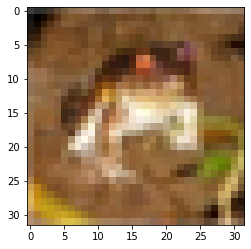

In [6]:
plt.imshow(x_train[0]), y_train[0]

### Train test split

In [7]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train)

x_train.shape, y_train.shape, x_val.shape, y_val.shape

((37500, 32, 32, 3), (37500, 10), (12500, 32, 32, 3), (12500, 10))

### Data generator

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 32

data_generator = ImageDataGenerator(
    width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)

train_generator = data_generator.flow(x_train, y_train, batch_size=batch_size)
step_per_epoch = x_train.shape[0] // batch_size

### Define, Complile and fit model

In [9]:
# Define Model

input_layer = Input(shape=(32, 32, 3))

conv11 = Conv2D(filters=32, kernel_size=(3, 3), strides=1, padding='same', kernel_initializer='HeNormal', kernel_regularizer=l2(1e-4))(input_layer)
conv11 = BatchNormalization()(conv11)
conv11 = relu(conv11)
conv12 = Conv2D(filters=32, kernel_size=(3, 3), strides=1, padding='same', kernel_initializer='HeNormal', kernel_regularizer=l2(1e-4))(conv11)
conv12 = BatchNormalization()(conv12)
conv12 = relu(conv12)
conv13 = Conv2D(filters=32, kernel_size=(3, 3), strides=1, padding='same', kernel_initializer='HeNormal', kernel_regularizer=l2(1e-4))(conv12)
conv13 = BatchNormalization()(conv13)
conv13 = relu(conv13)
maxpool1 = Conv2D(filters=32, kernel_size=(3, 3), strides=2, padding='same', kernel_initializer='HeNormal')(conv13)

conv21 = Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', kernel_initializer='HeNormal', kernel_regularizer=l2(1e-4))(maxpool1)
conv21 = BatchNormalization()(conv21)
conv21 = relu(conv21)
conv22 = Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', kernel_initializer='HeNormal', kernel_regularizer=l2(1e-4))(conv21)
conv22 = Add()([conv21, conv22])
conv22 = relu(conv22)
conv23 = Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', kernel_initializer='HeNormal', kernel_regularizer=l2(1e-4))(conv22)
conv23 = BatchNormalization()(conv23)
conv23 = relu(conv23)
maxpool2 = Conv2D(filters=32, kernel_size=(3, 3), strides=2, padding='same', kernel_initializer='HeNormal')(conv23)

conv31 = Conv2D(filters=128, kernel_size=(3, 3), strides=1, padding='same', kernel_initializer='HeNormal', kernel_regularizer=l2(1e-4))(maxpool2)
conv31 = BatchNormalization()(conv31)
conv31 = relu(conv31)
conv32 = Conv2D(filters=128, kernel_size=(3, 3), strides=1, padding='same', kernel_initializer='HeNormal', kernel_regularizer=l2(1e-4))(conv31)
conv32 = BatchNormalization()(conv32)
conv32 = relu(conv32)
conv33 = Conv2D(filters=128, kernel_size=(3, 3), strides=1, padding='same', kernel_initializer='HeNormal', kernel_regularizer=l2(1e-4))(conv32)
conv33 = BatchNormalization()(conv33)
conv33 = relu(conv33)
maxpool3 = Conv2D(filters=32, kernel_size=(3, 3), strides=2, padding='same', kernel_initializer='HeNormal')(conv33)

flatten = GlobalAveragePooling2D()(maxpool3)

output_layer = Dense(units=10, activation='softmax')(flatten)

model = Model(input_layer, output_layer)
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 32)   896         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 tf.nn.relu (TFOpLambda)        (None, 32, 32, 32)   0           ['batch_normalization[0][0]']

In [10]:
# Learning Rate Schedule

def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-2
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr


# opt = SGD(learning_rate=0.01, momentum=0.9, decay=0.0001)
opt = SGD(learning_rate=lr_schedule(0), momentum=0.9)

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])


Learning rate:  0.01


In [11]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.001),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)
# alpha = 0.01
# decay_steps = 25
# learning_rate = 0.1
# def cosine_decay(epoch):
#         step = min(epoch, 50)
#         cosine_decay = 0.5 * (1 + math.cos(math.pi * step / decay_steps))
#         decayed = (1 - alpha) * cosine_decay + alpha
#         return learning_rate * decayed



# initial_learning_rate = 0.01
# def schedule(epoch, lr):
#     if epoch < 200:
#         learning_rate = 0.01
#     else:
#         learning_rate = 0.1
#     return learning_rate



# LearningRateScheduler = LearningRateScheduler(cosine_decay)
early_stop = EarlyStopping(monitor='val_accuracy', mode='max', patience=50, restore_best_weights=True)
callbacks = [early_stop, lr_reducer, lr_scheduler]

In [ ]:
# Fit

model.fit(train_generator, epochs=600, validation_data=(x_val, y_val), callbacks= callbacks)

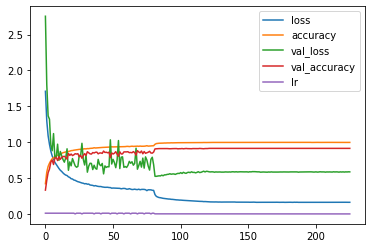

In [13]:
# Plot History

history = pd.DataFrame(model.history.history)
history.plot()

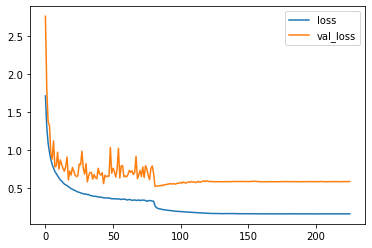

In [14]:
history[['loss', 'val_loss']].plot()

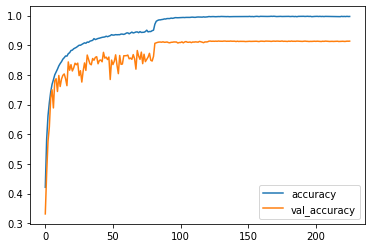

In [15]:
history[['accuracy', 'val_accuracy']].plot()

In [ ]:
# Save Model

model.save("cifar10.h5")

In [17]:
# Model Evaluate

model.evaluate(x_test, y_test)

313/313 [==============================] - 4s 12ms/step - loss: 0.6112 - accuracy: 0.9125


[0.6112092137336731, 0.9125000238418579]